In [1]:
import os
#os.environ['OPENBLAS_NUM_THREADS'] = '256'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd, os, numpy as np
#from scipy.stats import skew, kurtosis, entropy
#from tqdm import tqdm
from sklearn.mixture import GaussianMixture as gmm
import networkx.algorithms.community as nx_comm
import networkx as nx
import json as js
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick

In [2]:
sns.set_style({'axes.facecolor': 'white',
         'axes.edgecolor': 'black',
        'axes.grid': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'figure.facecolor':"white",
        'axes.labelcolor': '.15',
         'grid.color': 'white',
         'grid.linestyle': '-',
         'text.color': '.15',
         'xtick.color': '.15',
         'ytick.color': '.15',
        'patch.edgecolor': 'white',})

In [3]:
ROOT_DIR = "/N/slate/harryan/sim_data/"
TAR_DIR = "/N/slate/harryan/sim_data_extra/"

In [4]:
def gmm_optimal_cluster(data, max_clusters=3):
    """
    Find the optimal number of clusters using Gaussian mixture modeling.
    
    Parameters:
    data (numpy array): data set to be clustered
    max_clusters (int): maximum number of clusters to consider
    
    Returns:
    optimal_clusters (int): the optimal number of clusters
    """
    
    # Initialize the BIC score and number of clusters
    min_bic = np.inf
    optimal_clusters = None
    x = data.values.reshape(-1,1)
    # Loop over the number of clusters and fit a GMM to the data
    for k in range(1, max_clusters+1):
        GMM = gmm(n_components=k, n_init = 10, random_state=0).fit(x)
        
        # Calculate the BIC score and update the optimal number of clusters if necessary
        bic = GMM.bic(x)
        if bic < min_bic:
            min_bic = bic
            optimal_clusters = k
            membership= pd.DataFrame(GMM.predict(x))
        else:
            break
    return optimal_clusters, membership

In [5]:
def get(n, s, iteration):
    folder = f"/N/slate/harryan/sim_data/N{str(n)}/s{str(s)}eta5"
    print(folder, iteration)
    f_dir = f"{folder}/opinions/{str(iteration)}_opinions.parquet"
            #print(f_dir)
    op = pd.read_parquet(f_dir)
    nt_dir  = f"{folder}/networks/{str(iteration)}_networks.json"
    with open(nt_dir, "r") as f:
        last_edgelist = js.load(f)[op.columns[-1]]
    g_t = nx.from_edgelist(last_edgelist, create_using= nx.DiGraph)
    #n_t = nx.number_connected_components(g_t)
    n_cluster, mbsp = gmm_optimal_cluster(op[op.columns[-1]])
    return {"op": op, "G": g_t, "gmm_n": n_cluster, "mbsp": mbsp, "N":n, "s":s, "iter": iteration}

In [6]:
def node_color(mbsp):
    count = mbsp.value_counts()
    n = len(count)
    if n == 1:
        res = "grey"
    if n == 2:
        res = np.where(mbsp == 0, "red", "blue").flatten()
    colors = ["grey", "red", "blue", "purple", "green"]
    if n >2:
        res = mbsp.replace(count.index.to_list(), colors[:n]).values.flatten()
    return res

In [7]:
res = get(1, 9, 86)
#0, 0, 15/49

/N/slate/harryan/sim_data/N1/s9eta5 86


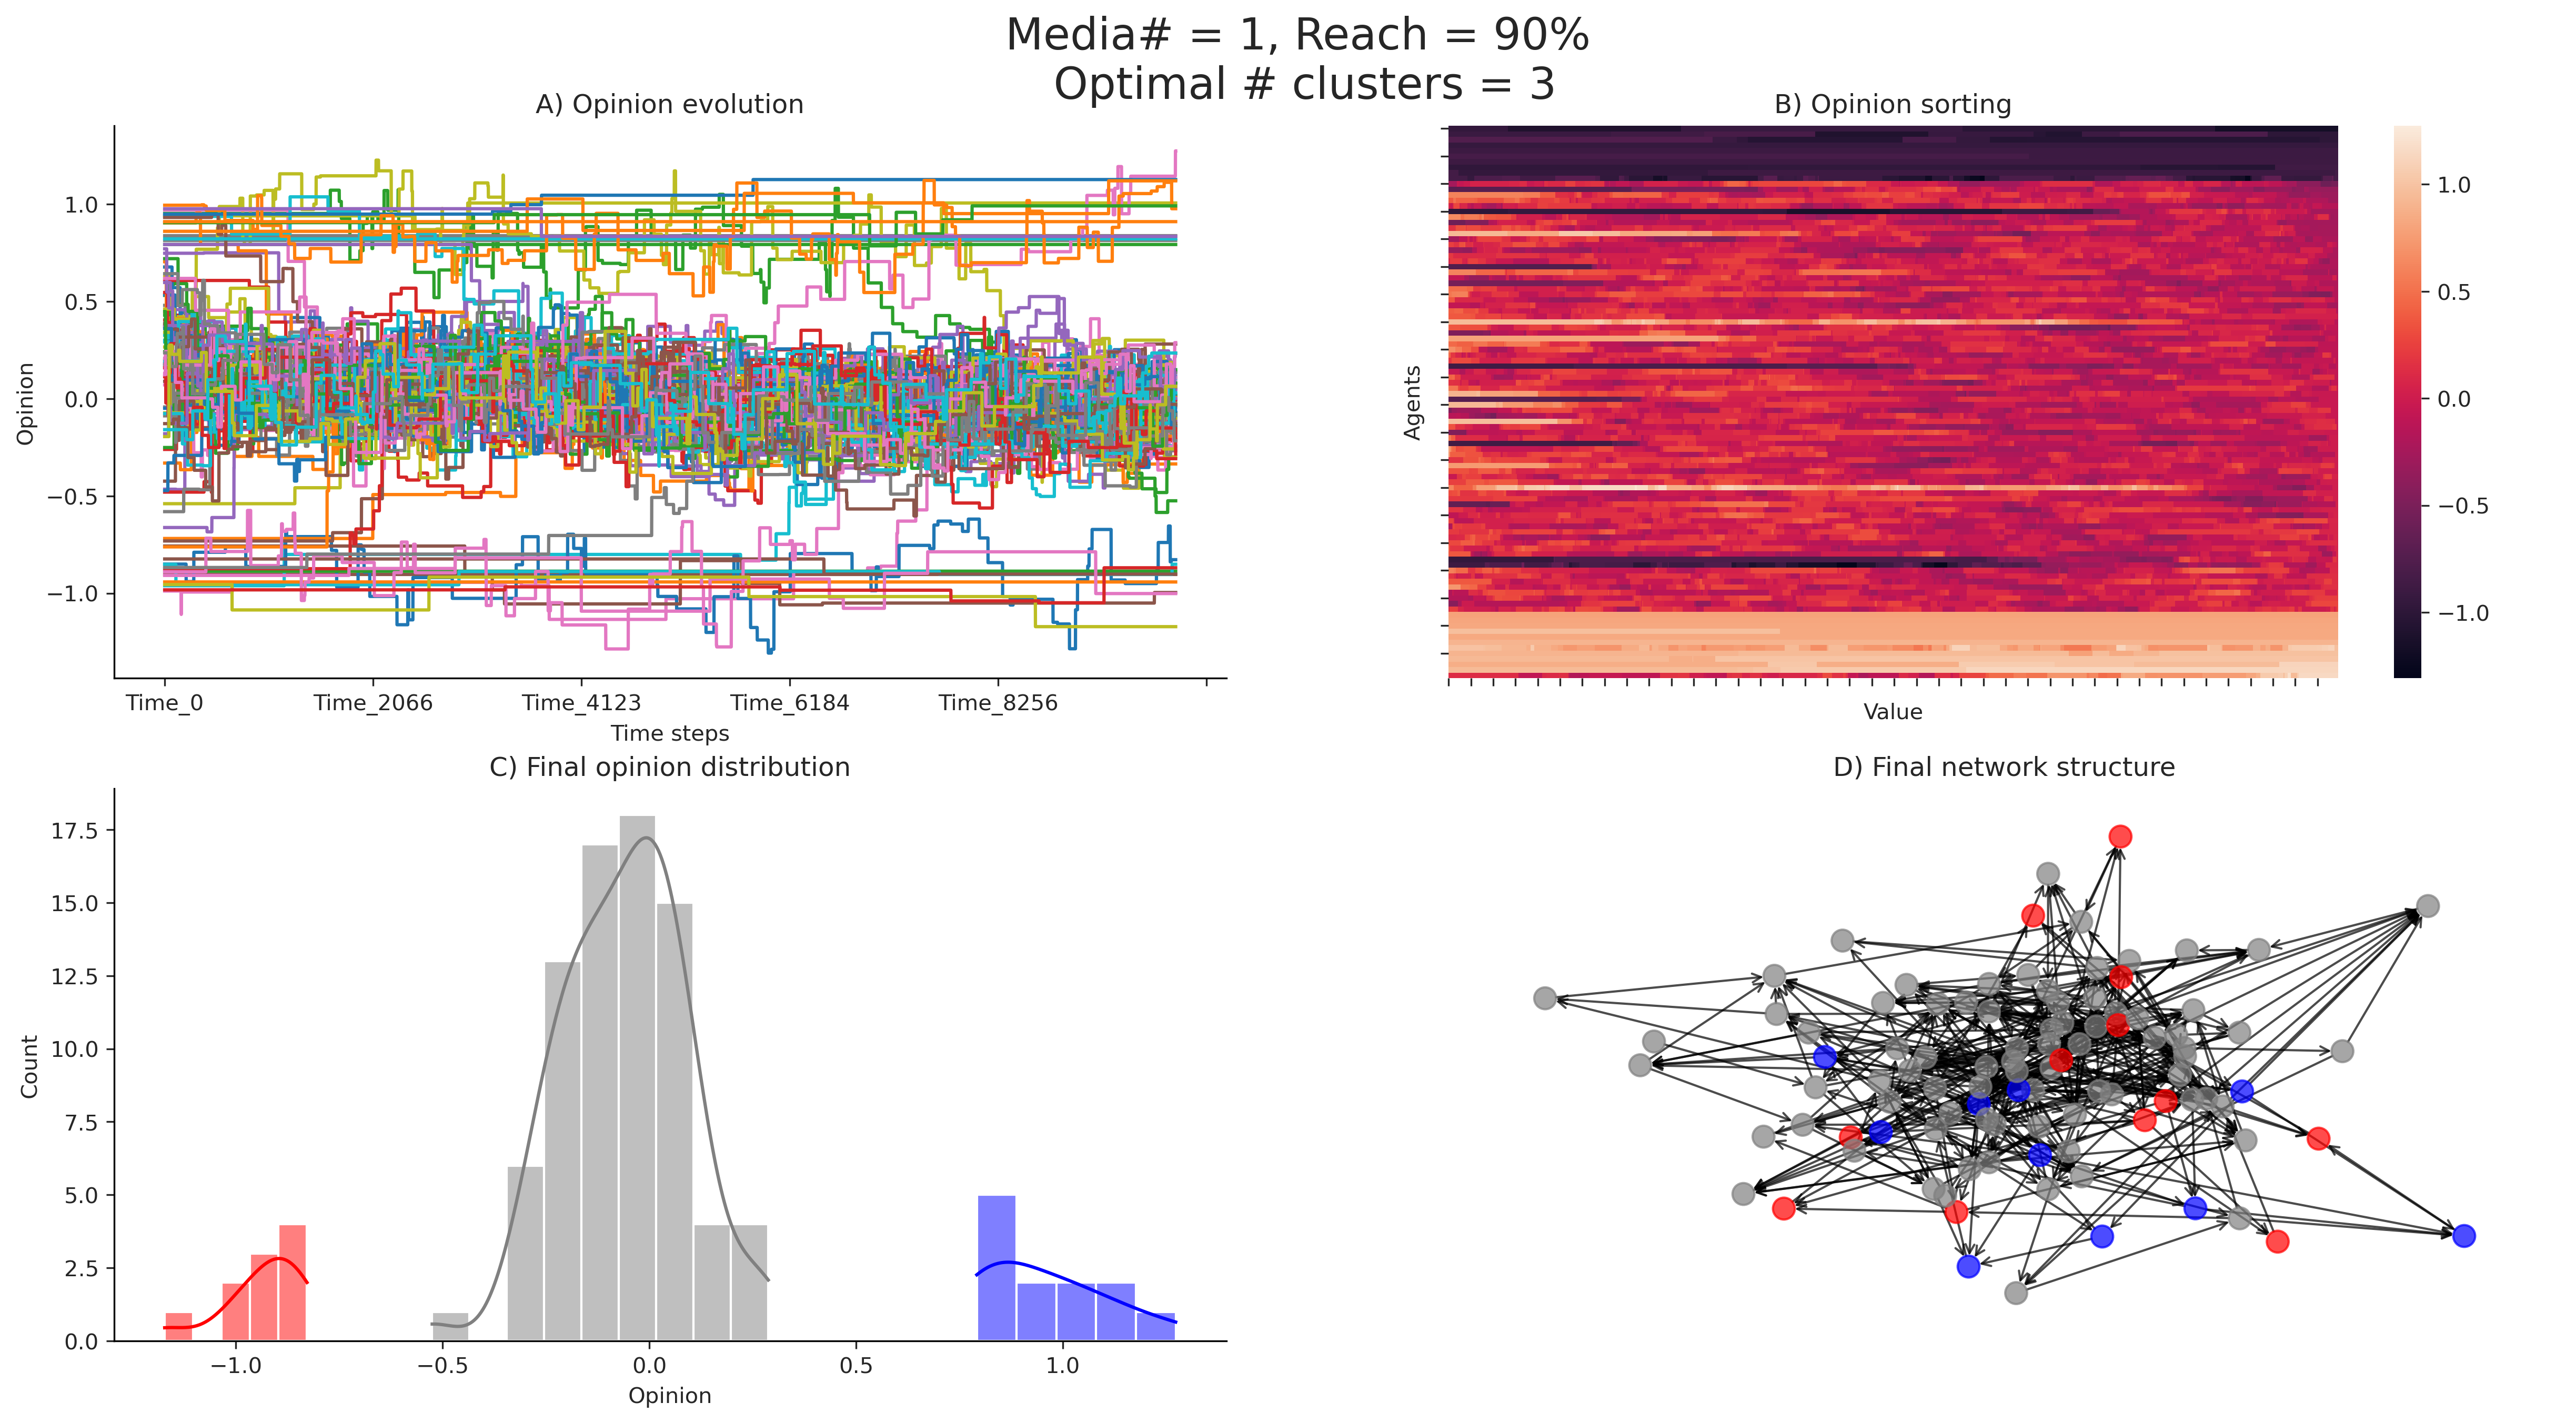

In [10]:
op = res["op"]
g_t = res["G"]
fig, axes = plt.subplots(2, 2, figsize = (5, 5), dpi = 300)
axes = axes.flatten()
op.T.plot(figsize = (20,10), ax = axes[0])
axes[0].legend().remove()
axes[0].set_xlabel("Values")
sns.heatmap(op.sort_values(by = op.columns[-1]), ax = axes[1])
#axes[1].set_title("Baseline", fontsize = 26)
axes[1].set_ylabel("Agents")
axes[1].set_xlabel("Time steps")
#axes[1].set_xticks(np.arange(10))
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
last = op[op.columns[-1]]
hist = pd.concat([last, res["mbsp"]], axis = 1)
sns.histplot(hist[hist[0]== 0]["Time_10000"],color = "gray", ax = axes[2], kde = True)
sns.histplot(hist[hist[0]== 1]["Time_10000"], color = "blue", ax = axes[2], kde = True)
sns.histplot(hist[hist[0]== 2]["Time_10000"], color = "red", ax = axes[2], kde = True)

pos = nx.spring_layout(g_t,  k = .4, iterations= 70)
nodes_color = pd.Series(node_color(res["mbsp"])).loc[list(g_t.nodes)]
nx.draw_networkx(g_t, pos = pos, alpha =.7, arrowstyle = "->", with_labels = False, node_size = 100, ax = axes[3], node_color = nodes_color)
#plt.suptitle(f"Media# = {str(res['N'])}, Reach = {str(res['s']*10)}%\n Optimal # clusters = {str(res['gmm_n'])}", y = .95, fontsize = 20)
axes[0].set_xlabel("Time steps")
axes[0].set_ylabel("Opinion")
axes[0].set_title("A) Opinion evolution")
axes[1].set_title("B) Opinion sorting")
axes[1].set_xlabel("Time steps")
axes[1].set_xlabel("Value")
axes[2].set_xlabel("Opinion")
axes[2].set_title("C) Final opinion distribution")
axes[3].set_title("D) Final network structure")
axes[3].spines[['bottom', 'left']].set_visible(False)
plt.suptitle(f"Media# = {str(res['N'])}, Reach = {str(res['s']*10)}%\n Optimal # clusters = {str(res['gmm_n'])}", y = .95, fontsize = 20)
plt.savefig("One_media.pdf")
#ax.set_title("eta = {}, T/c = {}, condition = Polarized".format(str(eta), str(np.around(T/c,2))))


In [13]:
node_color(res["mbsp"])

array([['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['blue'],
       ['grey'],
       ['red'],
       ['grey'],
       ['grey'],
       ['blue'],
       ['grey'],
       ['red'],
       ['grey'],
       ['grey'],
       ['blue'],
       ['grey'],
       ['red'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['red'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['blue'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['blue'],
       ['grey'],
       ['blue'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['blue'],
       ['red'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['grey'],
       ['blue'],
       ['grey'],
       ['grey'],
  

In [16]:
op[op.columns[-1]]

0     0.315527
1     0.492899
2    -0.636521
3    -0.364507
4     0.395313
        ...   
95   -0.888371
96   -0.575250
97    0.254564
98    0.094868
99    0.238971
Name: Time_10000, Length: 100, dtype: float64

0     blue
33    blue
47    blue
39    blue
98    blue
      ... 
76     red
57    blue
48    blue
85     red
94    blue
Length: 100, dtype: object